**Problèmatique** : est ce que les aides ont une influence sur le niveau d'endettement d'un menage 

x_debt_rel : tableau individus variables transformé et avec la dette relative

# Librairies

In [ ]:
!pip install geopandas
!pip install descartes 
!pip install merf
!pip install shap

     |████████████████████████████████| 962 kB 17.9 MB/s 
     |████████████████████████████████| 14.8 MB 92.4 MB/s 
     |████████████████████████████████| 6.4 MB 69.9 MB/s 
     |████████████████████████████████| 1.0 MB 71.7 MB/s 
     |████████████████████████████████| 82 kB 52.4 MB/s 
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 326 kB 20.1 MB/s 
     |████████████████████████████████| 68 kB 80.8 MB/s 
     |████████████████████████████████| 3.2 MB 83.2 MB/s 
     |████████████████████████████████| 25.3 MB 84.6 MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=385603 sha256=a7ed17090e1fccd9c49dcee0f73c41a125b1a08cf47c21c098aa55d3dbf5c03d
  Stored in directory:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from merf import MERF
from merf.viz import plot_merf_training_stats
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import shap

# Preprocessing data

In [ ]:
x = pd.read_csv("clients_menages_tabular.csv")

x['geo_cp']=x['geo_cp'].astype(str) #le dataset contient la variable code postal et pas département

x


,age_std_x,cnc_dteff,elo_categ_financement_inii,elo_dtf_construction,elo_etage,elo_mode_chauffage,geo_cp,geo_localite,geo_region_lib,mnt_aides_ccl_std_20180131,...,type_cnc_lib,type_elo_lib,type_revenu_lib_20181231,type_revenu_lib_20190930,type_trf_lib,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std,cnc_dtdval
0,50.0,2011-04-01,PLC,2006-03-01,Rez Chauss,-1,-1,-1,-1,0.0,...,Bail logemnt S05 conv,Type 4,All. Chomage_Indemnités,All. Chomage_Indemnités,Relocation,0.000000,0.0,0.0,0.00,2018-01-31
1,35.0,2011-06-15,PLC,2006-03-01,Rez Chauss,-1,-1,-1,-1,-417.0,...,Bail logemnt S05 conv,Type 4,-1,-1,Relocation,0.095238,0.0,0.0,0.00,2018-01-31
2,31.0,2015-01-27,PLC,2006-03-01,1° étage,-1,-1,-1,-1,-814.0,...,Bail logemnt S05 conv,Type 5,-1,-1,Relocation,0.000000,0.0,0.0,0.00,2018-01-31
3,48.0,2017-12-29,-1,2012-06-30,1° étage,-1,-1,-1,-1,0.0,...,Bail logemnt S05 conv,Type 4,-1,-1,Relocation,0.000000,0.0,0.0,0.00,2018-01-31
4,42.0,2018-07-05,PLC,2006-03-01,1° étage,-1,-1,-1,-1,0.0,...,Bail logemnt S05 conv,Type 5,All. Chomage_Indemnités,All. Chomage_Indemnités,Relocation,0.047619,0.0,0.0,599.77,2018-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19965,35.0,2019-04-02,-1,2019-04-02,RDC00,chauffage individuel gaz,64400,ESTOS,AQUITAINE,NaN,...,Bail logemnt S05 conv,Type 2,NaN,-1,Relocation,0.000000,0.0,0.0,285.07,2019-03-31
19966,50.0,2019-04-05,-1,2019-04-02,1° étage,chauffage individuel gaz,64400,ESTOS,AQUITAINE,NaN,...,Bail logemnt S05 conv,Type 3,NaN,-1,Relocation,0.111111,0.0,0.0,16.00,2019-04-30
19967,23.0,2019-04-05,-1,2019-04-02,1° étage,chauffage individuel gaz,64400,ESTOS,AQUITAINE,NaN,...,Bail logemnt S05 conv,Type 2,NaN,-1,Relocation,0.111111,0.0,0.0,306.36,2019-04-30
19968,25.0,2019-04-05,-1,2019-04-02,1° étage,chauffage individuel gaz,64400,ESTOS,AQUITAINE,NaN,...,Bail logemnt S05 conv,Type 3,NaN,-1,Relocation,0.111111,0.0,0.0,16.00,2019-04-30


In [ ]:
data_clean=0 #nouveau dataset avec toutes les variables transformées et propre

var = ['age_std_x', 'geo_cp', 'mnt_caution_dg_ccl_std']
data_clean = x[var]

## Moyenne des variables évoluant avec le temps

Variables :  mean_ressource, mean_revenu_imp, mean_fact, mean_enc, mean_rebt

la valeur cible de notre étude est de prédire la valeur moyenne de la dette 

In [ ]:
# RESSOURCES ET REVENUS

ressource = ['mnt_ressource_mensuel_std_20181231', 'mnt_ressource_mensuel_std_20190930']
revenu = ['mnt_revenu_imp_n_std_20181231', 'mnt_revenu_imp_n_std_20190930']

res = x[ressource]
res['mean_ressource']= res[ressource].mean(axis=1, skipna=True)
res = res.drop(ressource, axis=1)

rev = x[revenu]
rev['mean_revenu_imp']= rev[revenu].mean(axis=1, skipna=True)
rev = rev.drop(revenu, axis=1)

data_clean = pd.concat([data_clean, res], axis = 1)
data_clean = pd.concat([data_clean, rev], axis = 1)

# FACTURES 

fact = ['mnt_ttc_facture_ccl_std_20180131' , 'mnt_ttc_facture_ccl_std_20180228',  'mnt_ttc_facture_ccl_std_20180331', 'mnt_ttc_facture_ccl_std_20180430',
         'mnt_ttc_facture_ccl_std_20180531' , 'mnt_ttc_facture_ccl_std_20180630' , 'mnt_ttc_facture_ccl_std_20180731', 'mnt_ttc_facture_ccl_std_20180831', 
        'mnt_ttc_facture_ccl_std_20180930', 'mnt_ttc_facture_ccl_std_20181031', 'mnt_ttc_facture_ccl_std_20181130',
         'mnt_ttc_facture_ccl_std_20181231', 'mnt_ttc_facture_ccl_std_20190131', 'mnt_ttc_facture_ccl_std_20190228', 'mnt_ttc_facture_ccl_std_20190331', 
        'mnt_ttc_facture_ccl_std_20190430', 'mnt_ttc_facture_ccl_std_20190531', 'mnt_ttc_facture_ccl_std_20190630', 'mnt_ttc_facture_ccl_std_20190731',
        'mnt_ttc_facture_ccl_std_20190831', 'mnt_ttc_facture_ccl_std_20190930']
         
f = x[fact]
f['mean_fact']= f[fact].mean(axis=1, skipna=True)
f = f.drop(fact, axis=1)

data_clean = pd.concat([data_clean, f], axis = 1)

# ENCAISSEMENTS 

enc = ['mnt_total_encaisse_std_20180131' , 'mnt_total_encaisse_std_20180228',  'mnt_total_encaisse_std_20180331', 'mnt_total_encaisse_std_20180430',
         'mnt_total_encaisse_std_20180531' , 'mnt_total_encaisse_std_20180630' , 'mnt_total_encaisse_std_20180731', 'mnt_total_encaisse_std_20180831', 
        'mnt_total_encaisse_std_20180930', 'mnt_total_encaisse_std_20181031', 'mnt_total_encaisse_std_20181130',
         'mnt_total_encaisse_std_20181231', 'mnt_total_encaisse_std_20190131', 'mnt_total_encaisse_std_20190228', 'mnt_total_encaisse_std_20190331', 
        'mnt_total_encaisse_std_20190430', 'mnt_total_encaisse_std_20190531', 'mnt_total_encaisse_std_20190630', 'mnt_total_encaisse_std_20190731',
        'mnt_total_encaisse_std_20190831', 'mnt_total_encaisse_std_20190930']
         
e = x[enc]
e['mean_enc']= e[enc].mean(axis=1, skipna=True)
e = e.drop(enc, axis=1)

data_clean = pd.concat([data_clean, e], axis = 1)

# LOYERS

rent = ['mnt_loyer_ccl_std_20180131' , 'mnt_loyer_ccl_std_20180228',  'mnt_loyer_ccl_std_20180331', 'mnt_loyer_ccl_std_20180430',
         'mnt_loyer_ccl_std_20180531' , 'mnt_loyer_ccl_std_20180630' , 'mnt_loyer_ccl_std_20180731', 'mnt_loyer_ccl_std_20180831', 
        'mnt_loyer_ccl_std_20180930', 'mnt_loyer_ccl_std_20181031', 'mnt_loyer_ccl_std_20181130',
         'mnt_loyer_ccl_std_20181231', 'mnt_loyer_ccl_std_20190131', 'mnt_loyer_ccl_std_20190228', 'mnt_loyer_ccl_std_20190331', 
        'mnt_loyer_ccl_std_20190430', 'mnt_loyer_ccl_std_20190531', 'mnt_loyer_ccl_std_20190630', 'mnt_loyer_ccl_std_20190731',
        'mnt_loyer_ccl_std_20190831', 'mnt_loyer_ccl_std_20190930']
         
RE = x[rent]
RE['mean_rent']= RE[rent].mean(axis=1, skipna=True)
RE= RE.drop(rent, axis=1)

data_clean = pd.concat([data_clean, RE], axis = 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
# STATUTS DU FOYER

celib = ['nb_celibataire_std_20181231', 'nb_celibataire_std_20190930']
cel = x[celib]
cel['celib']= cel[celib].mean(axis=1, skipna=True)
cel = cel.drop(celib, axis=1)
data_clean = pd.concat([data_clean, cel], axis = 1)

concub = ['nb_concubin_std_20181231', 'nb_concubin_std_20190930']
concu = x[concub]
concu['concub']= concu[concub].mean(axis=1, skipna=True)
concu = concu.drop(concub, axis=1)
data_clean = pd.concat([data_clean, concu], axis = 1)

couple_av_enf = ['nb_couple_av_enf_std_20181231', 'nb_couple_av_enf_std_20190930']
AVE = x[couple_av_enf]
AVE['couple_av_enf']= AVE[couple_av_enf].mean(axis=1, skipna=True)
AVE = AVE.drop(couple_av_enf, axis=1)
data_clean = pd.concat([data_clean, AVE], axis = 1)

couple_ss_enf = ['nb_couple_ss_enf_std_20181231', 'nb_couple_ss_enf_std_20190930']
SSE = x[couple_ss_enf]
SSE['couple_ss_enf']= SSE[couple_ss_enf].mean(axis=1, skipna=True)
SSE = SSE.drop(couple_ss_enf, axis=1)
data_clean = pd.concat([data_clean, SSE], axis = 1)

divorce = ['nb_divorce_std_20181231', 'nb_divorce_std_20190930']
DIV = x[divorce]
DIV['divorce']= DIV[divorce].mean(axis=1, skipna=True)
DIV = DIV.drop(divorce, axis=1)
data_clean = pd.concat([data_clean, DIV], axis = 1)

marie = ['nb_marie_std_20181231', 'nb_marie_std_20190930']
MAR = x[marie]
MAR['marie']= MAR[marie].mean(axis=1, skipna=True)
MAR = MAR.drop(marie, axis=1)
data_clean = pd.concat([data_clean, MAR], axis = 1)

menage_autre = ['nb_menage_autre_std_20181231', 'nb_menage_autre_std_20190930']
AUT = x[menage_autre]
AUT['menage_autre']= AUT[menage_autre].mean(axis=1, skipna=True)
AUT = AUT.drop(menage_autre, axis=1)
data_clean = pd.concat([data_clean, AUT], axis = 1)

monopar = ['nb_monoparental_std_20181231', 'nb_monoparental_std_20190930']
MONO = x[monopar]
MONO['monopar']= MONO[monopar].mean(axis=1, skipna=True)
MONO = MONO.drop(monopar, axis=1)
data_clean = pd.concat([data_clean, MONO], axis = 1)

pacse = ['nb_pacse_std_20181231', 'nb_pacse_std_20190930']
PAC = x[pacse]
PAC['pacse']= PAC[pacse].mean(axis=1, skipna=True)
PAC = PAC.drop(pacse, axis=1)
data_clean = pd.concat([data_clean, PAC], axis = 1)

separe = ['nb_separe_std_20181231', 'nb_separe_std_20190930']
SEP = x[separe]
SEP['separe']= SEP[separe].mean(axis=1, skipna=True)
SEP = SEP.drop(separe, axis=1)
data_clean = pd.concat([data_clean, SEP], axis = 1)

seul = ['nb_seul_std_20181231', 'nb_seul_std_20190930']
ALONE = x[seul]
ALONE['seul']= ALONE[seul].mean(axis=1, skipna=True)
ALONE = ALONE.drop(seul, axis=1)
data_clean = pd.concat([data_clean, ALONE], axis = 1)

veuf = ['nb_veuf_std_20181231', 'nb_veuf_std_20190930']
MORT = x[veuf]
MORT['veuf']= MORT[veuf].mean(axis=1, skipna=True)
MORT = MORT.drop(veuf, axis=1)
data_clean = pd.concat([data_clean, MORT], axis = 1)

nb_enf = ['nbr_enfant_std_20181231', 'nbr_enfant_std_20190930']
NBENF = x[nb_enf]
NBENF['nb_enf']= NBENF[nb_enf].mean(axis=1, skipna=True)
NBENF = NBENF.drop(nb_enf, axis=1)
data_clean = pd.concat([data_clean, NBENF], axis = 1)

nb_menage = ['nbr_occupant_menage_std_20181231', 'nbr_occupant_menage_std_20190930']
NBP = x[nb_menage]
NBP['nb_menage']= NBP[nb_menage].mean(axis=1, skipna=True)
NBP = NBP.drop(nb_menage, axis=1)
data_clean = pd.concat([data_clean, NBP], axis = 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

## Solde relatif et nombre de mois de location

In [ ]:
Solde = ['solde_std_20180131', 'solde_std_20180228', 'solde_std_20180331', 'solde_std_20180430', 'solde_std_20180531', 'solde_std_20180630', 'solde_std_20180731',
        'solde_std_20180831', 'solde_std_20180930', 'solde_std_20181031', 'solde_std_20181130', 'solde_std_20181231', 'solde_std_20190131', 'solde_std_20190228',
        'solde_std_20190331', 'solde_std_20190430', 'solde_std_20190531', 'solde_std_20190630', 'solde_std_20190731', 'solde_std_20190831', 'solde_std_20190930']

debt = ['debt_20180131', 'debt_20180228', 'debt_20180331', 'debt_20180430', 'debt_20180531', 'debt_20180630', 'debt_20180731',
            'debt_20180831', 'debt_20180930', 'debt_20181031', 'debt_20181130', 'debt_20181130', 'debt_20181231', 'debt_20190131',
            'debt_20190228', 'debt_20190331', 'debt_20190430', 'debt_20190531', 'debt_20190630',  'debt_20190731', 
            'debt_20190831', 'debt_20190930']
s = x[Solde] 

s = s.mask(s < 0, 0)  #no debt

# NOMBRE DE MOIS DE LOCATION
nb = x[Solde] 
nb['nb_mois']=nb.count(axis=1)
nb = nb.drop(Solde, axis=1)
data_clean = pd.concat([data_clean, nb], axis = 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
s_rent = pd.concat([s, RE], axis = 1)

s_rent['debt_20180131'] = (s_rent['solde_std_20180131']/s_rent['mean_rent'])
s_rent['debt_20180228'] = (s_rent['solde_std_20180228'])/s_rent['mean_rent']
s_rent['debt_20180331'] = (s_rent['solde_std_20180331'])/s_rent['mean_rent']
s_rent['debt_20180430'] = (s_rent['solde_std_20180430'])/s_rent['mean_rent']
s_rent['debt_20180531'] = (s_rent['solde_std_20180531'])/s_rent['mean_rent']
s_rent['debt_20180630'] = (s_rent['solde_std_20180630'])/s_rent['mean_rent']
s_rent['debt_20180731'] = (s_rent['solde_std_20180731'])/s_rent['mean_rent']
s_rent['debt_20180831'] = (s_rent['solde_std_20180831'])/s_rent['mean_rent']
s_rent['debt_20180930'] = (s_rent['solde_std_20180930'])/s_rent['mean_rent']
s_rent['debt_20181031'] = (s_rent['solde_std_20181031'])/s_rent['mean_rent']
s_rent['debt_20181130'] = (s_rent['solde_std_20181130'])/s_rent['mean_rent']
s_rent['debt_20181231'] = (s_rent['solde_std_20181231'])/s_rent['mean_rent']
s_rent['debt_20190131'] = (s_rent['solde_std_20190131'])/s_rent['mean_rent']
s_rent['debt_20190228'] = (s_rent['solde_std_20190228'])/s_rent['mean_rent']
s_rent['debt_20190331'] = (s_rent['solde_std_20190331'])/s_rent['mean_rent']
s_rent['debt_20190430'] = (s_rent['solde_std_20190430'])/s_rent['mean_rent']
s_rent['debt_20190531'] = (s_rent['solde_std_20190531'])/s_rent['mean_rent']
s_rent['debt_20190630'] = (s_rent['solde_std_20190630'])/s_rent['mean_rent']
s_rent['debt_20190731'] = (s_rent['solde_std_20190731'])/s_rent['mean_rent']
s_rent['debt_20190831'] = (s_rent['solde_std_20190831'])/s_rent['mean_rent']
s_rent['debt_20190930'] = (s_rent['solde_std_20190930'])/s_rent['mean_rent']

s_rent['sum_debt']= s_rent[debt].sum(axis=1)

s_rent = s_rent.drop(Solde, axis=1)
s_rent = s_rent.drop(['mean_rent'], axis=1)

x_debt_rel = pd.concat([data_clean, s_rent], axis = 1)

x_debt_rel['mean_debt']=x_debt_rel.sum_debt/x_debt_rel.nb_mois

## Aides absolues

In [ ]:
help = ['mnt_aides_ccl_std_20180131' , 'mnt_aides_ccl_std_20180228',  'mnt_aides_ccl_std_20180331', 'mnt_aides_ccl_std_20180430',
         'mnt_aides_ccl_std_20180531' , 'mnt_aides_ccl_std_20180630' , 'mnt_aides_ccl_std_20180731', 'mnt_aides_ccl_std_20180831', 
        'mnt_aides_ccl_std_20180930', 'mnt_aides_ccl_std_20181031', 'mnt_aides_ccl_std_20181130',
         'mnt_aides_ccl_std_20181231', 'mnt_aides_ccl_std_20190131', 'mnt_aides_ccl_std_20190228', 'mnt_aides_ccl_std_20190331',
         'mnt_aides_ccl_std_20190430', 'mnt_aides_ccl_std_20190531', 'mnt_aides_ccl_std_20190630', 'mnt_aides_ccl_std_20190731', 
        'mnt_aides_ccl_std_20190831', 'mnt_aides_ccl_std_20190930']

aides_rel = ['aides_20180131', 'aides_20180228', 'aides_20180331', 'aides_20180430', 'aides_20180531',
             'aides_20180630', 'aides_20180731', 'aides_20180831', 'aides_20180930', 'aides_20181031', 
             'aides_20181130', 'aides_20181231', 'aides_20190131', 'aides_20190228', 'aides_20190430',
             'aides_20190531', 'aides_20190630', 'aides_20190731', 'aides_20190831', 'aides_20190930']
h = x[help]

h_rent = pd.concat([h, RE], axis = 1)

h_rent['aides_20180131'] = (h_rent['mnt_aides_ccl_std_20180131']/h_rent['mean_rent'])
h_rent['aides_20180228'] = (h_rent['mnt_aides_ccl_std_20180228'])/h_rent['mean_rent']
h_rent['aides_20180331'] = (h_rent['mnt_aides_ccl_std_20180331'])/h_rent['mean_rent']
h_rent['aides_20180430'] = (h_rent['mnt_aides_ccl_std_20180430'])/h_rent['mean_rent']
h_rent['aides_20180531'] = (h_rent['mnt_aides_ccl_std_20180531'])/h_rent['mean_rent']
h_rent['aides_20180630'] = (h_rent['mnt_aides_ccl_std_20180630'])/h_rent['mean_rent']
h_rent['aides_20180731'] = (h_rent['mnt_aides_ccl_std_20180731'])/h_rent['mean_rent']
h_rent['aides_20180831'] = (h_rent['mnt_aides_ccl_std_20180831'])/h_rent['mean_rent']
h_rent['aides_20180930'] = (h_rent['mnt_aides_ccl_std_20180930'])/h_rent['mean_rent']
h_rent['aides_20181031'] = (h_rent['mnt_aides_ccl_std_20181031'])/h_rent['mean_rent']
h_rent['aides_20181130'] = (h_rent['mnt_aides_ccl_std_20181130'])/h_rent['mean_rent']
h_rent['aides_20181231'] = (h_rent['mnt_aides_ccl_std_20181231'])/h_rent['mean_rent']
h_rent['aides_20190131'] = (h_rent['mnt_aides_ccl_std_20190131'])/h_rent['mean_rent']
h_rent['aides_20190228'] = (h_rent['mnt_aides_ccl_std_20190228'])/h_rent['mean_rent']
h_rent['aides_20190331'] = (h_rent['mnt_aides_ccl_std_20190331'])/h_rent['mean_rent']
h_rent['aides_20190430'] = (h_rent['mnt_aides_ccl_std_20190430'])/h_rent['mean_rent']
h_rent['aides_20190531'] = (h_rent['mnt_aides_ccl_std_20190531'])/h_rent['mean_rent']
h_rent['aides_20190630'] = (h_rent['mnt_aides_ccl_std_20190630'])/h_rent['mean_rent']
h_rent['aides_20190731'] = (h_rent['mnt_aides_ccl_std_20190731'])/h_rent['mean_rent']
h_rent['aides_20190831'] = (h_rent['mnt_aides_ccl_std_20190831'])/h_rent['mean_rent']
h_rent['aides_20190930'] = (h_rent['mnt_aides_ccl_std_20190930'])/h_rent['mean_rent']

h_rent['sum_aides']= h_rent[aides_rel].sum(axis=1)

h_rent = h_rent.drop(help, axis=1)
h_rent = h_rent.drop(['mean_rent'], axis=1)

x_debt_rel = pd.concat([x_debt_rel, h_rent], axis = 1)

x_debt_rel['mean_aides']=x_debt_rel.sum_aides/x_debt_rel.nb_mois

In [ ]:
x_debt_rel

,age_std_x,geo_cp,mnt_caution_dg_ccl_std,mean_ressource,mean_revenu_imp,mean_fact,mean_enc,mean_rent,celib,concub,...,aides_20190228,aides_20190331,aides_20190430,aides_20190531,aides_20190630,aides_20190731,aides_20190831,aides_20190930,sum_aides,mean_aides
0,50.0,-1,0.00,0.0,30269.0,525.175714,528.095238,511.442857,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,35.0,-1,0.00,0.0,0.0,323.062857,266.491905,487.699524,0.0,0.0,...,-0.209166,-0.209166,-0.209166,-0.209166,-0.209166,-0.209166,0.000000,-0.209166,-7.471301,-0.355776
2,31.0,-1,0.00,0.0,0.0,335.230000,394.373810,651.149048,0.0,1.0,...,-1.400002,-0.417723,-0.417723,-0.417723,-0.417723,-0.417723,-0.417723,0.000000,-10.384274,-0.494489
3,48.0,-1,0.00,0.0,10720.0,540.241905,542.743810,525.628571,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,42.0,-1,599.77,865.0,0.0,202.252381,99.710000,419.076190,0.0,1.0,...,-1.107126,-1.107126,-1.107126,-1.107126,-1.107126,-1.107126,-1.107126,0.000000,-12.185732,-0.580273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19965,35.0,64400,285.07,0.0,14507.0,266.864444,266.864444,210.868889,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19966,50.0,64400,16.00,0.0,11463.0,106.111111,106.111111,241.688889,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,-2.632972,-1.316486,-1.316486,-1.316486,-6.582429,-0.731381
19967,23.0,64400,306.36,0.0,3304.0,121.722222,188.976667,195.780000,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.822403,-1.233630,-6.056032,-0.672892
19968,25.0,64400,16.00,0.0,0.0,97.213333,97.213333,243.272222,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,-2.788399,-1.394199,-1.394199,-1.394199,-6.970997,-0.774555


<AxesSubplot:xlabel='mean_debt', ylabel='mean_aides'>

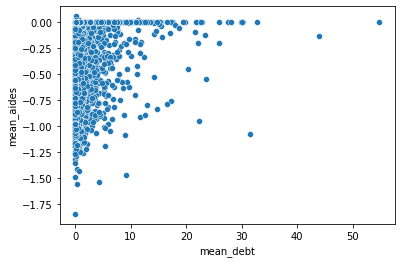

In [ ]:
    sns.scatterplot(data=x_debt_rel, x="mean_debt", y="mean_aides")

In [ ]:
# prétraitement pour garder que les valeurs moyennes de la dette
col1 = list(x_debt_rel.columns)[23:44]
# prétraitement pour garder que les valeurs moyennes de l'aide 
col2 = list(x_debt_rel.columns)[46:67]
col3 = [ "sum_debt"]
to_select = x_debt_rel[x_debt_rel.columns.difference(col1)]
to_select_item = to_select[to_select.columns.difference(col2)]
selected_item = to_select_item[to_select_item.columns.difference(col3)]
selected_item


,age_std_x,celib,concub,couple_av_enf,couple_ss_enf,divorce,geo_cp,marie,mean_aides,mean_debt,...,mnt_caution_dg_ccl_std,monopar,nb_enf,nb_menage,nb_mois,pacse,separe,seul,sum_aides,veuf
0,50.0,0.0,0.0,0.5,0.5,0.0,-1,1.0,0.000000,0.001702,...,0.00,0.0,0.0,2.5,21,0.0,0.0,0.0,0.000000,0.0
1,35.0,0.0,0.0,1.0,0.0,0.0,-1,1.0,-0.355776,0.020325,...,0.00,0.0,0.0,3.0,21,0.0,0.0,0.0,-7.471301,0.0
2,31.0,0.0,1.0,1.0,0.0,0.0,-1,0.0,-0.494489,0.512117,...,0.00,0.0,0.0,4.0,21,0.0,0.0,0.0,-10.384274,0.0
3,48.0,1.0,0.0,0.0,0.0,0.0,-1,0.0,0.000000,0.059851,...,0.00,1.0,0.0,2.0,21,0.0,0.0,0.0,0.000000,0.0
4,42.0,0.0,1.0,1.0,0.0,0.0,-1,0.0,-0.580273,3.411199,...,599.77,0.0,4.0,6.0,21,0.0,0.0,0.0,-12.185732,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19965,35.0,1.0,0.0,0.0,0.0,0.0,64400,0.0,0.000000,0.150209,...,285.07,0.0,0.0,1.0,9,0.0,0.0,1.0,0.000000,0.0
19966,50.0,0.0,0.0,0.0,0.0,1.0,64400,0.0,-0.731381,0.000000,...,16.00,1.0,1.0,2.0,9,0.0,0.0,0.0,-6.582429,0.0
19967,23.0,1.0,0.0,0.0,0.0,0.0,64400,0.0,-0.672892,0.164788,...,306.36,0.0,0.0,1.0,9,0.0,0.0,1.0,-6.056032,0.0
19968,25.0,1.0,0.0,1.0,0.0,0.0,64400,0.0,-0.774555,0.000000,...,16.00,0.0,1.0,2.0,9,0.0,0.0,0.0,-6.970997,0.0


In [ ]:
select_data = selected_item.apply(pd.to_numeric, downcast='float')
select_data = select_data.replace([np.inf, -np.inf], np.nan).dropna()
np.any(np.isnan(select_data))

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.feature_selection import SelectPercentile, f_classif
y_train = select_data["mean_debt"]
y_train = y_train.apply(pd.to_numeric, downcast='float')
y_train = y_train.replace([np.inf, -np.inf], np.nan).dropna()
fs = SelectPercentile(f_classif, percentile=66) # 66 a été selectioné pour ne pas inclure le cp car non discriminant.
# expliquer f_classif = test de l'Anova
train_minus_target = select_data.drop("mean_debt", axis=1)
x_features = fs.fit_transform(train_minus_target, y_train)
select_data = pd.DataFrame(x_features)
select_data.insert(0,"mean_debt",y_train)


In [ ]:
print(train_minus_target.columns[fs.get_support()]) 


Index(['concub', 'couple_av_enf', 'marie', 'mean_aides', 'mean_enc',
       'mean_fact', 'mean_ressource', 'menage_autre', 'mnt_caution_dg_ccl_std',
       'monopar', 'nb_enf', 'nb_menage', 'nb_mois', 'pacse', 'separe',
       'sum_aides'],
      dtype='object')


## standardisation de données

le clustering par kmeans nécesite d'opérer sur des données standardisées 

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_X = sc_X.fit_transform(select_data)
 # appliquer StandardScaler 

sc_X = pd.DataFrame(data=sc_X, columns=["concub", "couple_av_enf", "marie", "mean_aides","mean_enc" ,"mean_fact","mean_ressource", "menage_autre", "mnt_caution_dg_ccl_std", "monopar","nb_enf", "nb_menage", "nb_mois", "pacse", "separe", "sum_aides", "mean_debt"]
)
sc_X
sc_X = sc_X.replace([np.inf, -np.inf], np.nan).dropna()


## Traitement pour la visualisation

pour avoir un retour visuel sur les données ; T-sne permet de faire de l'embeding des données et genere des attributs par rapport à des dimenssions définies.

In [ ]:
#tsne = TSNE(n_components= 3, init='pca', random_state=42).fit_transform(sc_X)
#tsne.shape

## Normalisation 
pour bien cadrer le domaine des données , j'ai choisi une normalisation MinMax pour assortir les données.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(select_data)
scaled_features = scaler.transform(sc_X)
# on effectue le feature scaling
df_MinMax = pd.DataFrame(data=scaled_features, columns=["concub","mean_enc", "couple_av_enf", "marie", "mean_aides", "mean_fact","mean_ressource", "menage_autre", "mnt_caution_dg_ccl_std", "monopar","nb_enf", "nb_menage", "nb_mois", "pacse", "separe", "sum_aides", "mean_debt"])
df_MinMax = df_MinMax.replace([np.inf, -np.inf], np.nan).dropna()
df_MinMax

,concub,mean_enc,couple_av_enf,marie,mean_aides,mean_fact,mean_ressource,menage_autre,mnt_caution_dg_ccl_std,monopar,nb_enf,nb_menage,nb_mois,pacse,separe,sum_aides,mean_debt
0,-0.004080,0.191573,0.870301,1.703086,1.427391,0.076475,0.105188,0.152463,0.27936,-0.000449,-0.012864,-0.010357,0.096142,-0.725774,0.380613,0.183761,0.993430
1,-0.003852,0.191573,1.681439,1.703086,0.874742,0.075626,0.104556,0.152463,0.27936,-0.000449,-0.012864,-0.010357,0.143139,-0.725774,0.380613,0.183761,0.966560
2,0.002176,2.322200,1.681439,0.073324,0.659271,0.076041,0.104594,0.152463,0.27936,-0.000449,-0.012864,-0.010357,0.237134,-0.725774,0.380613,0.183761,0.956084
3,-0.003368,0.191573,0.059162,0.073324,1.427391,0.076523,0.105235,0.152463,0.27936,-0.000449,1.459139,-0.010357,0.049145,-0.725774,0.380613,0.183761,0.993430
4,0.037711,2.322200,1.681439,0.073324,0.526018,0.075084,0.104179,0.153749,0.27936,0.003040,-0.012864,0.572468,0.425123,-0.725774,0.380613,0.183761,0.949605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19959,-0.003372,0.191573,0.059162,0.073324,1.427391,0.075627,0.104381,0.152463,0.27936,0.001210,-0.012864,-0.010357,-0.044849,-1.036650,0.380613,0.183761,0.993430
19960,-0.002256,0.191573,0.059162,0.073324,0.291293,0.075105,0.103878,0.152463,0.27936,-0.000356,1.459139,0.135349,0.049145,-1.036650,0.380613,0.183761,0.969757
19961,-0.002195,0.191573,0.059162,0.073324,0.382146,0.075374,0.103927,0.152463,0.27936,0.001333,-0.012864,-0.010357,-0.044849,-1.036650,0.380613,0.183761,0.971650
19962,-0.002260,0.191573,1.681439,0.073324,0.224227,0.075076,0.103851,0.152463,0.27936,-0.000356,-0.012864,0.135349,0.049145,-1.036650,0.380613,0.183761,0.968360


## Optimisation pour le nombre de cluster

On utilise la méthode de coude pour selectionner un nombre optimum de cluster selon les données.

In [ ]:
kmeans_kwargs = {
     "init": "random",
      "n_init": 10,
     "max_iter": 300,
     "random_state": 42, }

wcss = []
for k in range(1, 11):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
   kmeans.fit(df_MinMax)
   wcss.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), wcss)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

NameError: name 'KMeans' is not defined

## Clustering
ce traitement est effectuées sûr les données déja étudiées pour le protocole 4

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_MinMax)
labeles = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster =kmeans.fit_predict(df_MinMax)

## Visulisation 
on utilisant les données en cluster et les dimension de T-sne, on arrive à ce résultat.

NameError: name 'tsne' is not defined

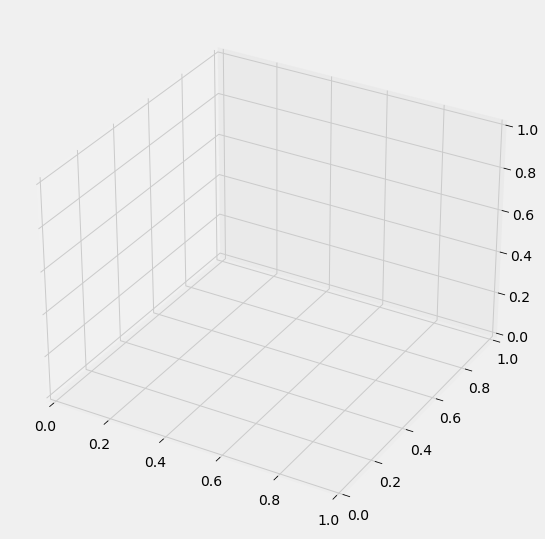

In [ ]:
figure = plt.figure(figsize=(9,9))
axes = figure.add_subplot(111,projection = "3d")
dots = axes.scatter(xs = tsne[:,0],ys = tsne[:,1],zs = tsne[:,2],
                   c = labeles, cmap = plt.cm.get_cmap("nipy_spectral_r",10))

## Regression et Confrontation des modéles

Utilisation des données en forme de cluster pour quelles soient considéres comme random effect par la suite,
 

-   MERF : 
Mixed effect Random forest permet de génere des coefficients béta qui permettent de donnée l'effet des catégories:




In [ ]:
#choix du jeu de données et variable de localisation
data = df_MinMax

#ajouter la donnée indiquant le cluster
labels_dataframe = pd.DataFrame(labeles, columns=['labeles']).astype(str)

data = pd.concat([data, labels_dataframe], axis = 1)


In [ ]:
data = df_MinMax
labels_dataframe = pd.DataFrame(labeles, columns=['labeles'])  
data = pd.concat([data, labels_dataframe], axis = 1)
loc = 'labeles'
data = data.replace([np.inf, -np.inf], np.nan).dropna()
np.any(np.isnan(data))
data[loc]=data[loc].astype(str)

data = data.replace([np.inf, -np.inf], np.nan).dropna()
grouped = data.groupby("labeles").mean()
grouped




,concub,mean_enc,couple_av_enf,marie,mean_aides,mean_fact,mean_ressource,menage_autre,mnt_caution_dg_ccl_std,monopar,nb_enf,nb_menage,nb_mois,pacse,separe,sum_aides,mean_debt
labeles,,,,,,,,,,,,,,,,,
0,-0.000133,0.191996,0.154375,0.074080,1.047256,0.075794,0.104552,0.152533,0.279360,-0.000153,-0.001748,0.008387,-0.028088,-0.749456,0.535828,0.305367,0.975568
1,-0.000701,0.191573,1.068614,1.701963,1.031645,0.076078,0.104826,0.152546,0.280525,-0.000045,-0.010430,0.094083,0.167558,-0.745311,0.380613,0.184337,0.974882
2,0.000458,0.191573,0.063741,0.073324,0.791643,0.075733,0.104500,0.152533,0.280780,0.000111,1.448603,0.157617,0.104679,-0.758240,0.380613,0.728194,0.964089
3,0.000020,-0.750555,-0.566637,-0.597577,0.945565,0.075458,0.104243,0.152625,-1.077248,0.000536,-0.520780,-0.038730,-0.078195,-0.725774,-1.580155,-0.729097,0.970004
4,0.000793,2.319211,1.031436,0.073324,1.064099,0.076030,0.104793,0.152558,0.284103,0.000159,0.049502,0.086126,0.153267,-0.755780,0.380613,0.184347,0.976697
5,-0.000166,0.247874,0.070930,0.075857,0.948674,0.075890,0.104645,0.152526,2.895374,-0.000095,-0.005237,0.033732,0.072863,-0.746069,0.380613,0.548431,0.970609


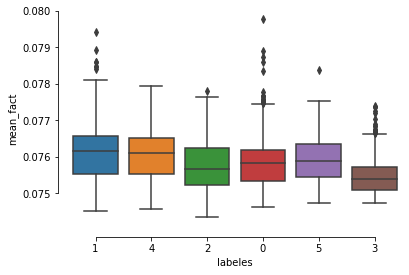

In [ ]:
sns.boxplot(x="labeles", y="mean_fact",
            data=data)
sns.despine(offset=10, trim=True)

In [ ]:



# data splitting 
Xtr, Xte, ytr, yte = model_selection.train_test_split(data.drop(columns=['mean_debt']), data.mean_debt, test_size=0.30, random_state=0)

# Mixed Effects Random Forest Training
mrf = MERF()
loc = 'labeles'
# we remove the clustering variable as it is considerate a random effect
X_tr =  Xtr.drop(columns= [loc])
Z_tr = np.ones((len(X_tr), 1))
clusters_train = Xtr[loc]
mrf.fit(X_tr, Z_tr, clusters_train, ytr)

# Mixed Effects Random Forest Test
X_test = Xte.drop(columns= [loc])
Z_test = np.ones((len(X_test), 1))
clusters_test = Xte[loc]
y_predicted_mrf = mrf.predict(X_test, Z_test, clusters_test)

#critère de performance MSE
mse=mean_squared_error(yte, y_predicted_mrf)
print('MSE avec les clusters : {}'.format(mse))

INFO     [merf.py:307] Training GLL is -114046.33055789275 at iteration 1.
INFO     [merf.py:307] Training GLL is -227330.538723222 at iteration 2.
INFO     [merf.py:307] Training GLL is -265826.5458173319 at iteration 3.
INFO     [merf.py:307] Training GLL is -265831.0392865666 at iteration 4.
INFO     [merf.py:307] Training GLL is -265301.73185198335 at iteration 5.
INFO     [merf.py:307] Training GLL is -266102.06652592466 at iteration 6.
INFO     [merf.py:307] Training GLL is -268843.06887124554 at iteration 7.
INFO     [merf.py:307] Training GLL is -269175.83025650214 at iteration 8.
INFO     [merf.py:307] Training GLL is -268721.2915390918 at iteration 9.
INFO     [merf.py:307] Training GLL is -266429.14530622127 at iteration 10.
INFO     [merf.py:307] Training GLL is -264399.8055213549 at iteration 11.
INFO     [merf.py:307] Training GLL is -263534.55211110064 at iteration 12.
INFO     [merf.py:307] Training GLL is -264987.6739608614 at iteration 13.
INFO     [merf.py:307] Train

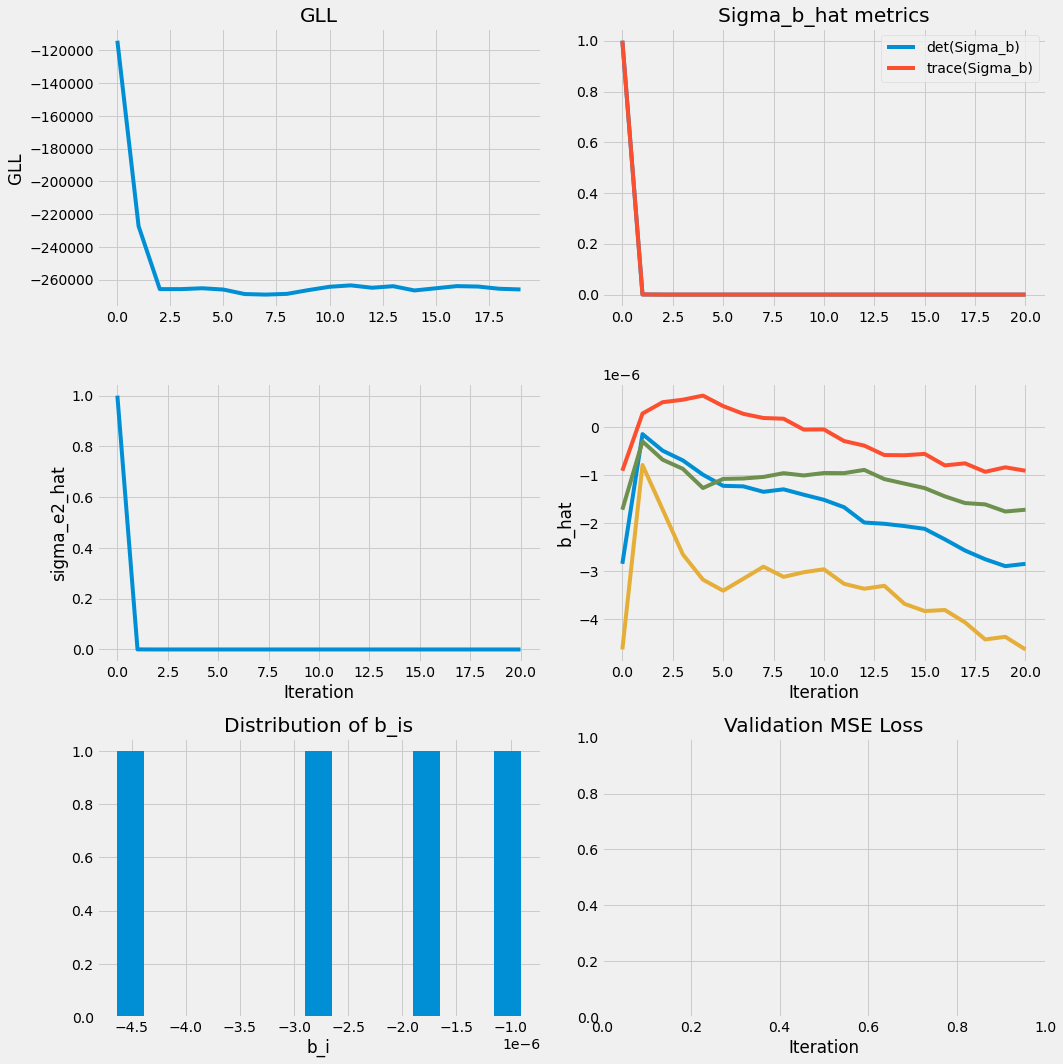

In [ ]:
plot_merf_training_stats(mrf, num_clusters_to_plot=4)

-   Random forest sans clusters: une baseline pour comparer l'effet du clustering sur la performance du modéle

In [ ]:
#choix du jeu de données et variable de localisation
data = df_MinMax
from sklearn.ensemble import RandomForestRegressor
Xtr, Xte, ytr, yte = model_selection.train_test_split(data.drop(columns=['mean_debt']), data.mean_debt, test_size=0.30, random_state=0)

#apprentissage
clf = RandomForestRegressor(n_estimators=100)
clf = clf.fit(Xtr,ytr)

#critère de performance
y_predicted = clf.predict(Xte)
mse=mean_squared_error(yte, y_predicted)
print('MSE sans les clusters: {}'.format(mse))

MSE sans les clusters: 1.358941984961217e-07


-   Random forest avec clusters: une réference pour comparer l'étude en mixed effect par rapport au modél MERF pour les random effet induite.


In [ ]:
#choix du jeu de données et variable de localisation
data = df_MinMax
labels_dataframe = pd.DataFrame(labeles, columns=['labeles'])  
data = pd.concat([data, labels_dataframe], axis = 1)
loc = 'labeles'
data = data.replace([np.inf, -np.inf], np.nan).dropna()
np.any(np.isnan(data))
data[loc]=data[loc].astype(str)

data = data.replace([np.inf, -np.inf], np.nan).dropna()

Xtr, Xte, ytr, yte = model_selection.train_test_split(data.drop(columns=['mean_debt']), data.mean_debt, test_size=0.30, random_state=0)

#apprentissage
clf = RandomForestRegressor(n_estimators=100)
clf = clf.fit(Xtr,ytr)

#critère de performance
y_predicted = clf.predict(Xte)
mse=mean_squared_error(yte, y_predicted)
print('MSE avec les clusters: {}'.format(mse))

MSE avec les clusters: 1.349251050094865e-07
